# Harmonic Model

### Imports

In [1]:
import dft_model as dft
import matplotlib.pyplot as plt
import numpy as np
import sine_model as sm
import utility_functions as uf

from scipy.fftpack import ifft
from scipy.signal import blackmanharris, get_window, triang

%matplotlib inline

### Set up some parameters

In [2]:
n = 2048     # FFT size
n_s = 512    # size of FFT for synthesis
h = n_s / 4  # hop size
t = -90      # magnitude threshold of spectral peaks (dB)
n_h = 100    # max number of harmonics
min_f0 = 100 # min freq for fundamental
max_f0 = 300 # max ...
f0_e = 7     # maximum error accepted in f0 detection
min_sine_duration = 0.1 # minimum duration of a detected sinewave
harm_dev_slope = 0.01   # allowed deviation of harmonic tracks; allows higher harmonics to have greater deviation 
m = 1201     # window size
window = 'blackman'
w = get_window(window, m)
input_file = '../sms-tools/sounds/vignesh.wav'
!play '../sms-tools/sounds/vignesh.wav'


../sms-tools/sounds/vignesh.wav:

 File Size: 273k      Bit Rate: 706k
  Encoding: Signed PCM    
  Channels: 1 @ 16-bit   
Samplerate: 44100Hz      
Replaygain: off         
  Duration: 00:00:03.09  

In:100%  00:00:03.09 [00:00:00.00] Out:136k  [      |      ]        Clip:0    
Done.


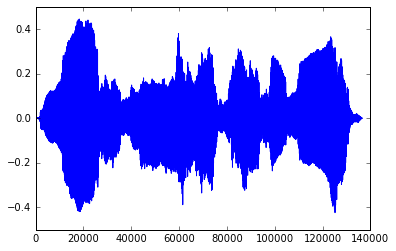

In [3]:
# Read input sound
(fs, x) = uf.wavread(input_file)
plt.plot(x);

## Begin Analysis

In [4]:
# Set up
h_n = n / 2                              # size of positive spectrum 
h_m1 = int(np.floor((w.size + 1) / 2))   # half analysis window size by rounding
h_m2 = int(np.floor(w.size / 2))         # half analysis window size by floor 
x = np.append(np.zeros(h_m2), x)         # zero-pad at beginning to center first window at sample 0
x = np.append(x, np.zeros(h_m2))         # zero-pad the end to analyze last sample
p_in = h_m1                              # init sound pointer in middle of anal window
p_end = x.size - h_m1                    # last sample to start a frame 
fft_buffer = np.zeros(n)                 # initialize buffer for FFT
w = w / sum(w)                           # normalize analysis window 
h_freq_p = []                            # initialize harmonic frequencies of previous frame
f0_t = 0                                 # initialize f0 track
f0_stable = 0                            # initialize f0 stable

### Function for Harmonic Detection 

In [5]:
def harmonic_detection(p_freq, p_mag, p_phase, f0, n_h, h_freq_p, fs, harm_dev_slope = 0.01):
    '''
    Detection of the harmonics of a frame from a set of spectral peaks using f0
    to the ideal harmonic series built on top of a fundamental frequency
    p_freq, p_mag, p_phase: peak frequencies, magnitudes and phases
    f0: fundamental frequency
    n_h: number of harmonics
    h_freq_p: harmonic frequencies of previous frame
    fs: sampling rate
    harm_dev_slope: slope of change of the deviation allowed to perfect harmonic
    
    returns h_freq, h_mag, h_phase: harmonic frequencies, magnitudes, phases   
    '''
    # if no f0 return no harmonics
    if (f0 <= 0): 
        return np.zeros(n_h), np.zeros(n_h), np.zeros(n_h)
    
    h_freq = np.zeros(n_h) # initialize harmonic frequencies                                                                 
    h_mag = np.zeros(n_h) - 100 # initialize harmonic magnitudes                                                                  
    h_phase = np.zeros(n_h)     # initialize harmonic phases                                                                      
    h_f = f0 * np.arange(1, n_h + 1) # initialize harmonic frequencies                                                                 
    h_i = 0                          # initialize harmonic index                                                                       

    # if no incomming harmonic tracks initialize to harmonic series
    if h_freq_p == []:                                     
        h_freq_p = hf
    
    while (f0 > 0) and (h_i < n_h) and (h_f[h_i] < fs / 2):          
        # find harmonic peaks
        pe_i = np.argmin(abs(p_freq - h_f[h_i]))  # closest peak
        dev1 = abs(p_freq[pe_i] - h_f[h_i])       # deviation from perfect harmonic
        dev2 = (abs(p_freq[pe_i] - h_freq_p[h_i]) # deviation from previous frame
                if h_freq_p[h_i] > 0 
                else fs)
        threshold = f0 / 3 + harm_dev_slope * p_freq[pe_i]

        # accept peak if deviation is small                                                         
        if ((dev1 < threshold) or (dev2 < threshold)):
            h_freq[h_i]  = p_freq[pe_i]  # harmonic frequencies...
            h_mag[h_i]   = p_mag[pe_i]   # ...magnitudes...
            h_phase[h_i] = p_phase[pe_i] # ...and phases

        # increase harmonic index 
        h_i += 1                  
        
    return h_freq, h_mag, h_phase

In [6]:
# For all frames:
while p_in <= p_end:
    x1 = x[p_in - h_m1 : p_in + h_m2]       # select frame
    m_x, p_x = dft.dft_analysis(x1, w, n)   # compute dft
    p_loc = uf.peakDetection(m_x, t)        # detect peak locations
    ip_loc, ip_mag, ip_phase = uf.peakInterp(m_x, p_x, p_loc) # refine peak values with interpolation
    ip_freq = fs * ip_loc / n               # convert locations to Hz
    f0_t = uf.f0Twm(ip_freq, ip_mag, f0_t, min_f0, max_f0, f0_stable)  # find f0
    
    if ((f0_stable == 0) & (f0_t > 0)) or \
        ((f0_stable > 0) & 
         (np.abs(f0_stable - f0_t) < f0_stable / 5.0)):
        # consider a stable f0 if it is close to the previous one                          
        f0_stable = f0_t
    else:
        f0_stable = 0

    # Implement harmonic_detection() to find harmonics
    h_freq, h_mag, h_phase = harmonic_detection(
        ip_freq, ip_mag, ip_phase, f0_t, n_h, h_freq_p, fs, harm_dev_slope)

    h_freq_p = h_freq
    
    # if first frame
    if p_in == h_m1:
        x_h_freq  = np.array([h_freq])
        x_h_mag   = np.array([h_mag])
        x_h_phase = np.array([h_phase])
    else:
        x_h_freq  = np.vstack((x_h_freq,  np.array([h_freq])))
        x_h_mag   = np.vstack((x_h_mag,   np.array([h_mag])))
        x_h_phase = np.vstack((x_h_phase, np.array([h_phase])))
        
    # advance sound pointer
    p_in += h

/Users/dsp/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


In [7]:
# delete tracks shorter than minSineDur (see previous notebook, 03_sine_model.ipynb for details)
x_h_freq = sm.clean_sine_tracks(x_h_freq, round(fs * min_sine_duration / h))

In [8]:
h_freq  = x_h_freq
h_mag   = x_h_mag
h_phase = x_h_phase

In [10]:
# Synthesize harmonics
y = sm.sine_model_synthesis(h_freq, h_mag, h_phase, n_s, h, fs)

NameError: global name 'n_s' is not defined